In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from dpeva.uncertain.rnd import RandomNetworkDistillation

Initializing DP-EVA version 0.1.0


## Load descriptor example, 

descriptor shape : (nframe, ndim)

In [3]:
all_desc_stru = np.load('../data/desc.npy')
all_desc_stru.shape

(20873, 136)

## Random Network Distillation

The Random Network Distillation (RND) is a method to learn the representation of the environment and calculate the intrinsic reward of the target data. The idea is to train a neural network to predict the output of a fixed randomly initialized neural network. The fixed network is used to generate the target, and the trainable network is used to predict the target. The intrinsic reward is calculated by the difference between the target and the prediction which is used to train the agent to explore the environment. 

Here in MLIP active learning ,the 'agnet' is our MLIP and the environment is the atomistic space.

In [4]:
# randomly choose 50% of the data as training data
np.random.seed(19090)
train_index = np.random.choice(range(len(all_desc_stru)), int(0.5*len(all_desc_stru)), replace=False)
desc = all_desc_stru[train_index]
desc.shape

(10436, 136)

In [5]:
# parameters, can be tuned
input_dim = desc.shape[-1]  # input dimension
output_dim = 240  # output dimension
hidden_dim = 240  # hidden dimension
num_residual_blocks = 1  # number of residual blocks
device = "cpu"  # device

# initialization
rnd = RandomNetworkDistillation(
            input_dim=input_dim, 
            output_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_residual_blocks=num_residual_blocks, 
            distance_metric="cossim", 
            device=device)

# fit the predictor network
rnd.train(desc, 
          num_batches=4500,
          batch_size=2048,
          initial_lr=1e-3,
          gamma=0.98,
          decay_steps=20,
          disp_freq=200,
          save_freq=1000)

2025-01-13 17:52:47,061 - INFO - Target network saved to ./models/target_network.pth
2025-01-13 17:52:47,064 - INFO - Target network saved to ./models/target_network.pth
2025-01-13 17:52:47,065 - INFO - Training started.
2025-01-13 17:52:47,067 - INFO - Predictor network saved to ./models/predictor_network.pth
2025-01-13 17:52:47,560 - INFO - Initial batch loss: 0.999857
2025-01-13 17:52:47,581 - INFO - Batch 0/4500 trained, Time: 0.02s, Avg Loss: 0.696442
2025-01-13 17:52:50,773 - INFO - Batch 200/4500 trained, Time: 3.21s, Avg Loss: 0.019735
2025-01-13 17:52:53,977 - INFO - Batch 400/4500 trained, Time: 3.20s, Avg Loss: 0.001464
2025-01-13 17:52:57,269 - INFO - Batch 600/4500 trained, Time: 3.29s, Avg Loss: 0.000962
2025-01-13 17:53:00,669 - INFO - Batch 800/4500 trained, Time: 3.40s, Avg Loss: 0.000777
2025-01-13 17:53:03,970 - INFO - Batch 1000/4500 trained, Time: 3.30s, Avg Loss: 0.000678
2025-01-13 17:53:03,973 - INFO - Predictor network saved to ./models/predictor_network.pth
20

After training for predictor network, we can use the distance between target network and predictor network as the intrinsic reward for data to be sampled

In [6]:
%%time
intrinsic_rewards = []
batch_size = 4096 

# transform intrinsic_rewards to numpy array
intrinsic_rewards = rnd.eval_intrinsic_rewards(all_desc_stru, batch_size=batch_size)

2025-01-13 17:54:01,549 - INFO - Calculating intrinsic rewards for size 20873 with batch size 4096
2025-01-13 17:54:01,550 - INFO - Calculating intrinsic rewards for batch 1/6
2025-01-13 17:54:02,999 - INFO - Calculating intrinsic rewards for batch 2/6
2025-01-13 17:54:04,432 - INFO - Batch 2/6 completed, Time: 2.88s, 
2025-01-13 17:54:04,433 - INFO - Calculating intrinsic rewards for batch 3/6
2025-01-13 17:54:05,902 - INFO - Calculating intrinsic rewards for batch 4/6
2025-01-13 17:54:07,372 - INFO - Batch 4/6 completed, Time: 2.94s, 
2025-01-13 17:54:07,373 - INFO - Calculating intrinsic rewards for batch 5/6
2025-01-13 17:54:08,822 - INFO - Calculating intrinsic rewards for batch 6/6
2025-01-13 17:54:08,965 - INFO - Batch 6/6 completed, Time: 1.59s, 
2025-01-13 17:54:08,967 - INFO - Intrinsic rewards calculation done


CPU times: user 7.41 s, sys: 9.83 ms, total: 7.42 s
Wall time: 7.42 s


In [7]:
# top 200 unique points
top_50_indices = np.argsort(intrinsic_rewards)[-50:]  
top_50_points = all_desc_stru[top_50_indices]  

print("Indices of Top 200 points with highest intrinsic rewards:", top_50_indices)

Indices of Top 200 points with highest intrinsic rewards: [12465 19205  5740  5771  5761  7525  4221 18326 18889 12952 10367 13023
  8021 16049  2097   731   734  3449 20751 10815 18840  7522  7519 10805
 18342  7382  3613  1182 17444   723  1288  4109 18294  4474  4108  3599
 20750  4210 18806 18807 10101  7520   732 18805 13020 15273 11636  4224
  4225 18307]


## Visualizing the uncertainty (reward) results

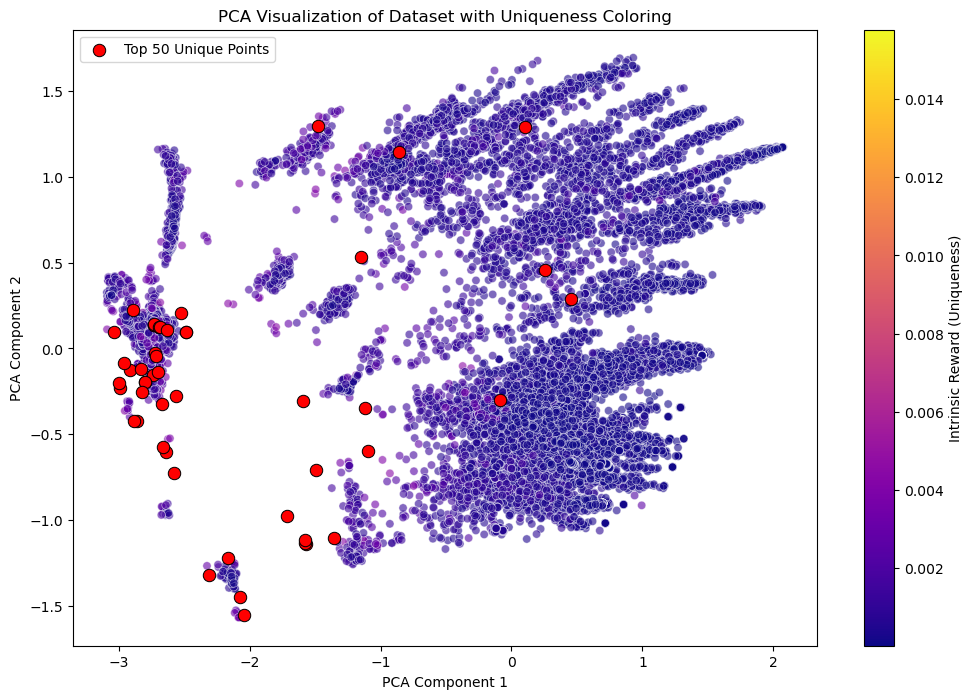

In [8]:
# PCA reduction
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(all_desc_stru) 
top_50_pca_result = pca.transform(top_50_points) # PCA reduction for top 200 unique points in the same space

plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

sns.scatterplot(
    x=top_50_pca_result[:, 0], y=top_50_pca_result[:, 1],
    color="red", label="Top 50 Unique Points", s=80, edgecolor="black"
)

norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

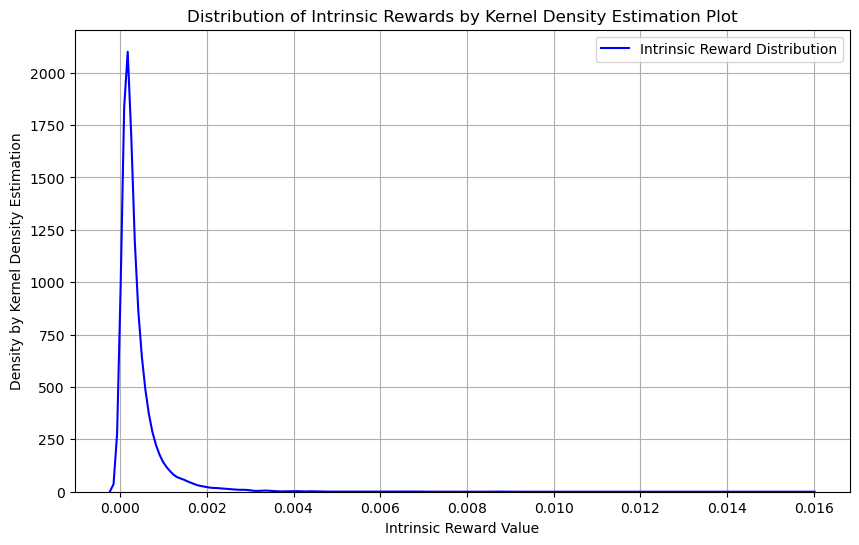

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 
plt.title("Distribution of Intrinsic Rewards by Kernel Density Estimation Plot")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density by Kernel Density Estimation")
plt.legend()
plt.grid(True)
plt.show()

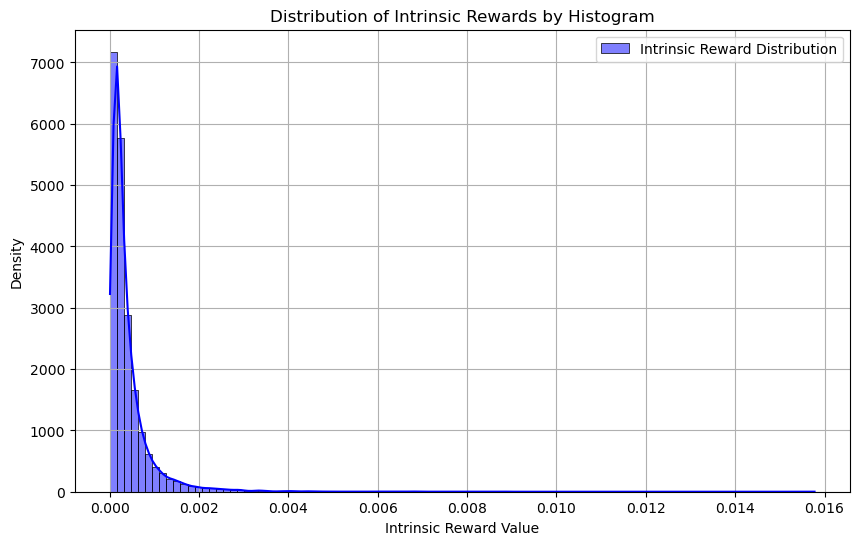

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=100, kde=True)
plt.title("Distribution of Intrinsic Rewards by Histogram")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()